In [1]:
import numpy as np
import cupy as cp
from holotomocupy.holo import G, GT
from holotomocupy.shift import S
from holotomocupy.tomo import R, RT
from holotomocupy.chunking import gpu_batch
from holotomocupy.recon_methods import multiPaganin
from holotomocupy.utils import *
from holotomocupy.proc import linear, dai_yuan
import sys

%matplotlib inline
# !jupyter nbconvert --to script rec_reprojection_codes.ipynb

astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 256  # object size in each dimension

ntheta = 360  # number of angles (rotations)
noise = 0
z1c = -19.5e-3
# thickness of the coded aperture
code_thickness = 1.8e-6 #in m
# feature size
ill_feature_size = 2e-6 #in m

# ntheta = int(sys.argv[1])  # number of angles (rotations)
# noise = int(sys.argv[2])#sys.argv[2]=='True'
# z1c = float(sys.argv[3])  # positions of the code and the probe for reconstruction

center = n/2 # rotation axis
theta = cp.linspace(0, np.pi, ntheta,endpoint=False).astype('float32')  # projection angles
npos = 1  # number of code positions
detector_pixelsize = 3e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = 4.584e-3-sx0# np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:npos]-sx0
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size
# magnification when propagating from the probe plane to the detector
magnifications2 = z1/z1c
distances2 = (z1-z1c)/(z1c/z1)#magnifications2
# allow padding if there are shifts of the probe
pad = n//8
# sample size after demagnification
ne = n+2*pad

show = True


flg = f'{n}_{z1c}'
flg0 = f'{2048}_{z1c}'
path = f'/data2/vnikitin/nfp_codes'


## Read data

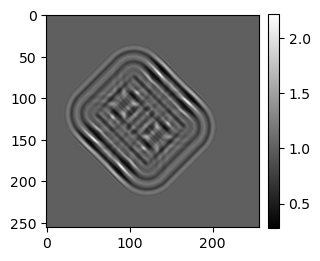

In [3]:
data = np.zeros([ntheta, npos, n, n], dtype='float32')
ref = np.zeros([1, npos, n, n], dtype='float32')
for k in range(npos):
    data[:, k] = read_tiff(f'{path}/data_3d_{k}_{flg}.tiff')[:ntheta]
for k in range(npos):
    ref[:, k] = read_tiff(f'{path}/ref_3d_{k}_{flg}.tiff')[:]

# data = cp.array(data)
# ref = cp.array(ref)
shifts_code = np.load(f'{path}/shifts_code_3d_{flg}.npy')
mshow(data[0,0],show)


# Construct operators


(1, 2560, 2560)


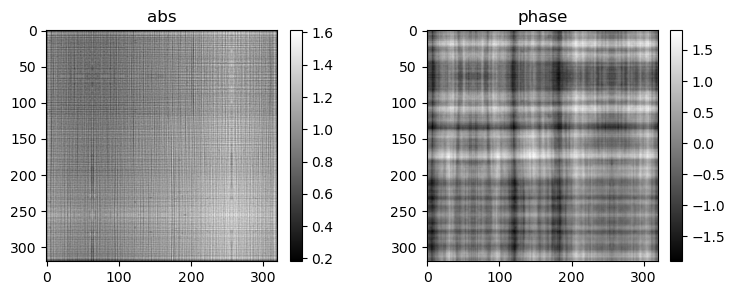

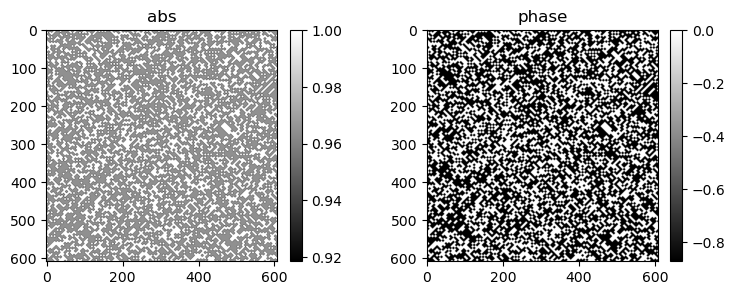

In [4]:
prb = np.load(f'{path}/prb_{flg0}.npy')
print(prb.shape)
for k in range(np.int32(np.log2(2048//n))):
    prb = 0.5*(prb[:,::2]+prb[:,1::2])
    prb = 0.5*(prb[:,:,::2]+prb[:,:,1::2])
mshow_polar(prb[0],show)

code = np.load(f'{path}/code_{flg0}.npy')
for k in range(np.int32(np.log2(2048//n))):
    code = 0.5*(code[:,::2]+code[:,1::2])
    code = 0.5*(code[:,:,::2]+code[:,:,1::2])
mshow_polar(code[0],show)

In [5]:
@gpu_batch
def _fwd_holo(psi, shifts_code, code, prb):
    #print(psi.shape)
    prb = cp.array(prb)
    code = cp.array(code)

    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi.copy()
        prbr = cp.tile(prb, [psi.shape[0], 1, 1])
        coder = cp.tile(code, [psi.shape[0], 1, 1])
        
        # shift and crop the code 
        coder = S(coder, shifts_code[:, i])
        coder = coder[:, coder.shape[1]//2-n//2-pad:coder.shape[1]//2+n//2+pad, coder.shape[1]//2-n//2-pad:coder.shape[1]//2+n//2+pad]
        # multiply by the probe
        coder *= prbr

        # propagate both to the sample plane
        coder = G(coder, wavelength, voxelsize, distances2[i])
        
        # multiply by the sample
        psir *= coder           

        # propagate all to the detector
        psir = G(psir, wavelength, voxelsize, distances[i])

        # unpad
        data[:, i] = psir[:, psir.shape[1]//2-n//2:psir.shape[1]//2+n//2, psir.shape[1]//2-n//2:psir.shape[1]//2+n//2]
        
    return data

@gpu_batch
def _adj_holo(data, shifts_code, prb, code):
    prb = cp.array(prb)
    code = cp.array(code)
    shifts_code = cp.array(shifts_code)
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64')
    for j in range(npos):
        prbr = cp.tile(prb,[psi.shape[0],1,1])        
        coder = cp.tile(code,[psi.shape[0],1,1])
        psir = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))
        psir = GT(psir, wavelength, voxelsize, distances[j])
        coder = S(coder, shifts_code[:,j])            
        coder = coder[:,ne-n//2-pad:ne+n//2+pad,ne-n//2-pad:ne+n//2+pad]        
        coder *= prbr
        coder = G(coder, wavelength, voxelsize, distances2[j])
        psir *= cp.conj(coder)
        psi += psir
    return psi

@gpu_batch
def _adj_holo_prb(data, shifts_code, psi, code):
    psi = cp.array(psi)
    code = cp.array(code)
    shifts_code = cp.array(shifts_code)       
    prb = cp.zeros([data.shape[0], n+2*pad, n+2*pad], dtype='complex64')
    for j in range(npos):
        prbr = np.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))
        coder = cp.tile(code,[psi.shape[0],1,1])
        psir = psi.copy()
        prbr = GT(prbr, wavelength, voxelsize, distances[j])
        prbr*=cp.conj(psir)
        prbr = GT(prbr, wavelength, voxelsize, distances2[j])
        coder = S(coder, shifts_code[:,j])            
        coder = coder[:, coder.shape[1]//2-n//2-pad:coder.shape[1]//2+n//2+pad, coder.shape[1]//2-n//2-pad:coder.shape[1]//2+n//2+pad]
        prbr *= cp.conj(coder)
        prb += prbr
    return prb

def fwd_holo(psi, prb):
    return _fwd_holo(psi, shifts_code, code, prb)
def adj_holo(data, prb):
    return _adj_holo(data, shifts_code, prb, code)
def adj_holo_prb(data, psi):
    ''' Adjoint Holography operator '''
    return np.sum(_adj_holo_prb(data, shifts_code, psi, code), axis=0)[np.newaxis]

# adjoint tests
tmp = data.copy()
arr1 = cp.pad(cp.array(tmp[:, 0]+1j*tmp[:, 0]).astype('complex64'),
              ((0, 0), (ne//2-n//2, ne//2-n//2), (ne//2-n//2, ne//2-n//2)), 'symmetric')

prb1 = cp.array(prb)#cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
code = cp.array(code)
shifts_code = cp.array(shifts_code)
arr2 = fwd_holo(arr1, prb1)
arr3 = adj_holo(arr2, prb1)
arr4 = adj_holo_prb(arr2, arr1)

print(f'{cp.sum(arr1*cp.conj(arr3))}==\n{cp.sum(arr2*cp.conj(arr2))}')
print(f'{cp.sum(prb1*cp.conj(arr4))}==\n{cp.sum(arr2*cp.conj(arr2))}')

arr1 = arr1.swapaxes(0,1)
a = RT(arr1,theta,ne//2)
b = R(a,theta,ne//2)
c = RT(b,theta,ne//2)
print(f'{cp.sum(arr1*cp.conj(b))}==\n{cp.sum(a*cp.conj(a))}')
print(f'{cp.sum(a*cp.conj(a))}==\n{cp.sum(a*cp.conj(c))}')

(38680000-39755.9140625j)==
(45913368-5.312839857651852e-05j)
(45913368-1.675048828125j)==
(45913368-5.312839857651852e-05j)
(73138248-1.5279278755187988j)==
(73138240-0.00017835652397479862j)
(73138240-0.00017835652397479862j)==
(74159768-1.4029383659362793j)


: 

### Propagate the code to the detector and divide all data by it

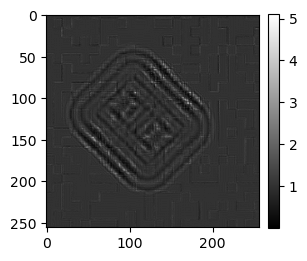

In [5]:
psi = cp.ones([ntheta,ne,ne],dtype='complex64')
prb = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
ref0 = cp.array(ref0)
data00 = cp.array(data00)
d = cp.abs(fwd_holo(psi,prb))**2

rdata = data00/d/ref0
mshow((rdata)[0,0],show)

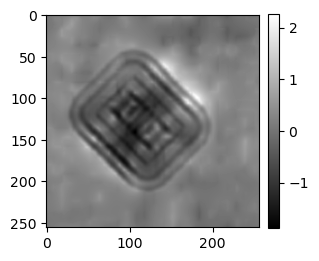

In [6]:
# distances should not be normalized
distances_pag = (distances)[:npos]
recMultiPaganin = np.exp(1j*multiPaganin(rdata,
                         distances_pag, wavelength, voxelsize,  100, 1e-12))
mshow(np.angle(recMultiPaganin[0]),show)

#### Exponential and logarithm functions for the Transmittance function

In [7]:

def exptomo(psi):
    """Exp representation of projections"""
    return np.exp(1j*psi * voxelsize * 2*cp.pi / wavelength*np.sqrt(ne*ntheta))
    
def logtomo(psi):
    """Log representation of projections, -i/\nu log(psi)"""
    res = psi.copy()
    res[np.abs(psi) < 1e-32] = 1e-32
    res = np.log(res)
    res = -1j * wavelength / (2*cp.pi) * res / voxelsize/np.sqrt(ne*ntheta)
    return res

# Operators for the flat field

In [8]:
@gpu_batch
def _fwd_holo0(prb):
    data = cp.zeros([1, npos, n, n], dtype='complex64')
    for j in range(npos):
        # propagate illumination
        data[:, j] = G(prb, wavelength, voxelsize, distances[0])[:, pad:n+pad, pad:n+pad]
    return data

def fwd_holo0(prb):
    return _fwd_holo0(prb)

@gpu_batch
def _adj_holo0(data):
    prb = cp.zeros([1, n+2*pad, n+2*pad], dtype='complex64')
    for j in range(npos):
        # ill shift for each acquisition
        prbr = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))
        # propagate illumination
        prbr = GT(prbr, wavelength, voxelsize, distances[0])
        # ill shift for each acquisition
        prb += prbr
    return prb

def adj_holo0(data):
    return _adj_holo0(data)


# adjoint test
data = data[0, :].copy()
ref = ref0.copy()
prb1 = cp.array(ref[0, :1]+1j*ref[0, :1]).astype('complex64')
prb1 = cp.pad(prb1, ((0, 0), (pad, pad), (pad, pad)))
arr2 = fwd_holo0(prb1)
arr3 = adj_holo0(arr2)


print(f'{np.sum(prb1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

(166440.890625-0.00701700896024704j)==
(166440.890625-2.9837874535587616e-06j)


In [9]:
def line_search(minf, gamma, fu, fd):
    """ Line search for the step sizes gamma"""
    while(minf(fu)-minf(fu+gamma*fd) < 0 and gamma > 1e-3):
        gamma *= 0.5
    if(gamma <= 1e-3):  # direction not found
        #print(f'{fu.shape} r no direction')
        gamma = 0
    return gamma

def cg_tomo(data, init, pars):
    """Conjugate gradients method for tomogarphy"""
    # minimization functional    
    @gpu_batch
    def _minf(Ru,data):
        res = cp.empty(data.shape[0],dtype='float32')
        for k in range(data.shape[0]):
            res[k] = np.linalg.norm(Ru[k]-data[k])**2
        return res
    
    def minf(Ru):
        res = np.sum(_minf(Ru,data))
        return res
    
    u = init.copy()
    center_pad = u.shape[-1]//2
    for i in range(pars['titer']):
        fu = R(u,theta,center_pad)
        grad = RT(fu-data,theta,center_pad)#/np.float32(np.prod(data.shape[1:]))
        # Dai-Yuan direction
        if i == 0:
            d = -grad
        else:
            d = dai_yuan(d,grad,grad0)

        grad0 = grad
        fd = R(d, theta, center_pad)
        gamma = line_search(minf, pars['gammau'], fu, fd)
        u = linear(u,d,1,gamma)   
        # print('t',i,minf(R(u,theta,center_pad)))
    return u


0), float(gammah)=0.677135169506073 err=1.43744e+04


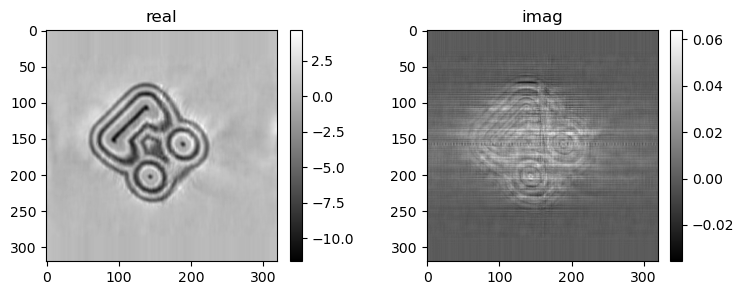

1), float(gammah)=2.2709667682647705 err=1.28060e+04
2), float(gammah)=1.2063615322113037 err=1.11291e+04
3), float(gammah)=1.6418969631195068 err=9.54450e+03
4), float(gammah)=1.6351525783538818 err=7.39936e+03
5), float(gammah)=1.1318883895874023 err=6.16981e+03
6), float(gammah)=1.6739979982376099 err=5.12372e+03
7), float(gammah)=1.1116572618484497 err=4.27988e+03
8), float(gammah)=1.3937186002731323 err=3.62079e+03


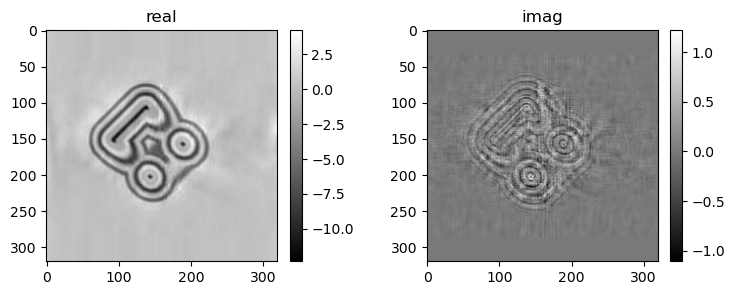

9), float(gammah)=1.6464418172836304 err=2.99539e+03
10), float(gammah)=1.5838303565979004 err=2.59714e+03
11), float(gammah)=1.6617145538330078 err=2.23048e+03
12), float(gammah)=1.3512868881225586 err=1.96768e+03
13), float(gammah)=1.4019583463668823 err=1.75342e+03
14), float(gammah)=1.2949175834655762 err=1.56601e+03
15), float(gammah)=1.3431340456008911 err=1.40072e+03
16), float(gammah)=1.4727685451507568 err=1.25409e+03


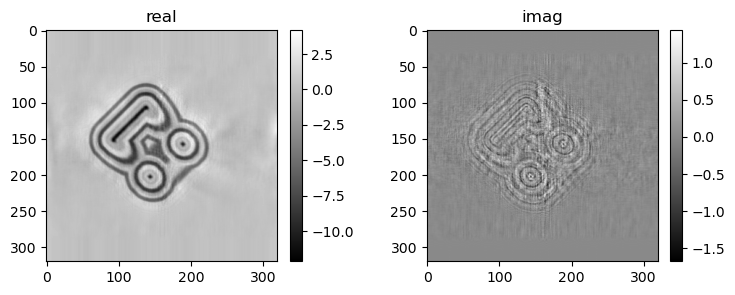

17), float(gammah)=1.4663195610046387 err=1.13051e+03
18), float(gammah)=1.526944637298584 err=1.02488e+03
19), float(gammah)=1.3768337965011597 err=9.35975e+02
20), float(gammah)=1.3497282266616821 err=8.62444e+02
21), float(gammah)=1.4225870370864868 err=7.94764e+02
22), float(gammah)=1.5854980945587158 err=7.32462e+02
23), float(gammah)=1.7347936630249023 err=6.76099e+02
24), float(gammah)=1.5256596803665161 err=6.31027e+02


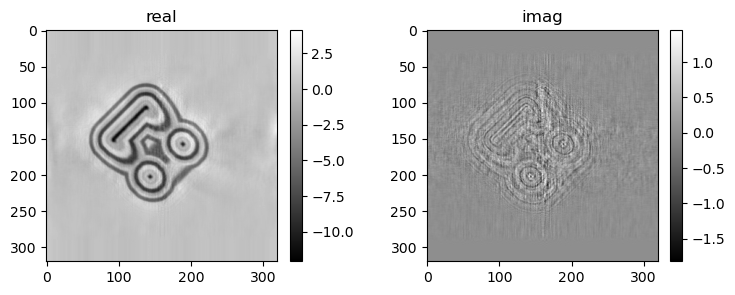

25), float(gammah)=1.4902923107147217 err=5.92630e+02
26), float(gammah)=1.461951494216919 err=5.57149e+02
27), float(gammah)=1.3233221769332886 err=5.28335e+02
28), float(gammah)=1.3397548198699951 err=5.00395e+02
29), float(gammah)=1.4393783807754517 err=4.76035e+02
30), float(gammah)=1.5950853824615479 err=4.52783e+02
31), float(gammah)=1.414110779762268 err=4.31728e+02
32), float(gammah)=1.6360901594161987 err=4.13579e+02


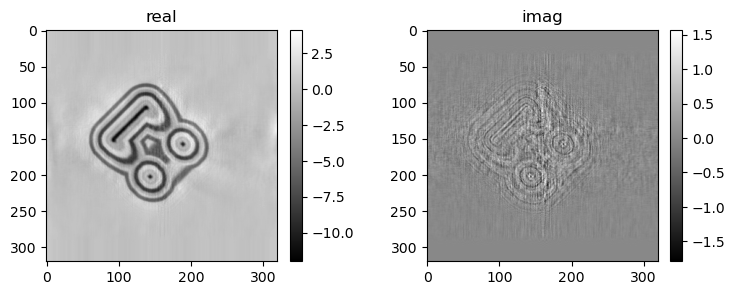

33), float(gammah)=1.6049309968948364 err=3.94864e+02
34), float(gammah)=1.298848271369934 err=3.80514e+02
35), float(gammah)=1.464459776878357 err=3.67333e+02
36), float(gammah)=1.6487778425216675 err=3.51697e+02
37), float(gammah)=1.408312201499939 err=3.39968e+02
38), float(gammah)=1.7998614311218262 err=3.27276e+02
39), float(gammah)=1.4500386714935303 err=3.16355e+02
40), float(gammah)=1.3807363510131836 err=3.07032e+02


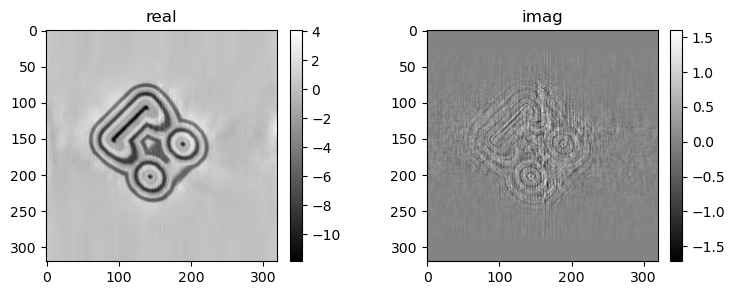

41), float(gammah)=1.3137073516845703 err=2.96954e+02
42), float(gammah)=1.6348600387573242 err=2.87610e+02
43), float(gammah)=1.796228289604187 err=2.77553e+02
44), float(gammah)=1.4249931573867798 err=2.69721e+02
45), float(gammah)=1.7972285747528076 err=2.60896e+02
46), float(gammah)=1.5583257675170898 err=2.52695e+02
47), float(gammah)=1.5865751504898071 err=2.45497e+02
48), float(gammah)=1.378538727760315 err=2.38536e+02


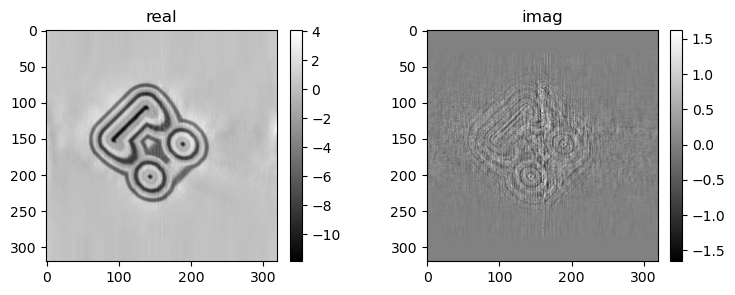

49), float(gammah)=1.396701455116272 err=2.31822e+02
50), float(gammah)=1.7405530214309692 err=2.24348e+02
51), float(gammah)=1.4976451396942139 err=2.18069e+02
52), float(gammah)=1.3889727592468262 err=2.12001e+02
53), float(gammah)=1.4187448024749756 err=2.05828e+02
54), float(gammah)=1.5035823583602905 err=1.99698e+02
55), float(gammah)=1.6072275638580322 err=1.93893e+02
56), float(gammah)=1.592403531074524 err=1.87672e+02


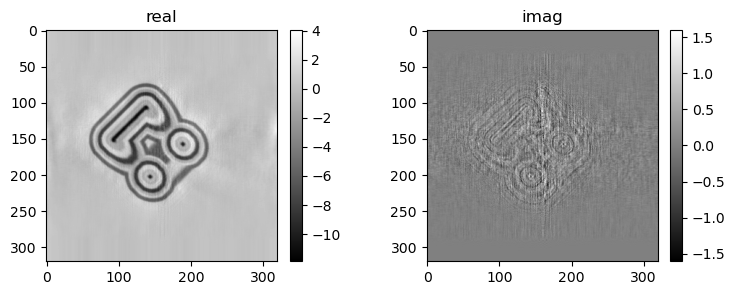

57), float(gammah)=1.5791555643081665 err=1.82147e+02
58), float(gammah)=1.733451008796692 err=1.76338e+02
59), float(gammah)=1.5326331853866577 err=1.71225e+02
60), float(gammah)=1.6970546245574951 err=1.65622e+02
61), float(gammah)=1.4707205295562744 err=1.60707e+02
62), float(gammah)=1.3890053033828735 err=1.56364e+02
63), float(gammah)=1.3344842195510864 err=1.51625e+02
64), float(gammah)=1.7289332151412964 err=1.46999e+02


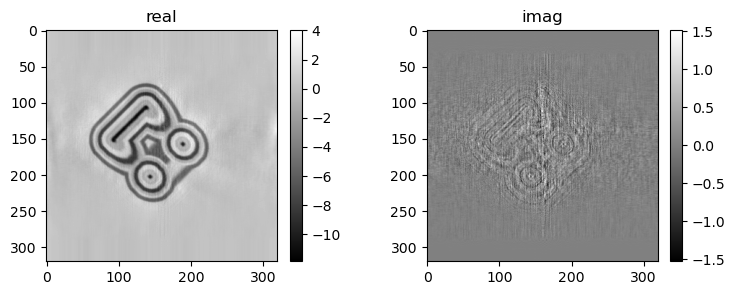

65), float(gammah)=1.7707583904266357 err=1.41844e+02
66), float(gammah)=1.3215099573135376 err=1.38221e+02
67), float(gammah)=1.5214564800262451 err=1.34058e+02
68), float(gammah)=1.4795074462890625 err=1.29845e+02
69), float(gammah)=1.7134358882904053 err=1.25907e+02
70), float(gammah)=1.5888259410858154 err=1.21893e+02
71), float(gammah)=1.7480944395065308 err=1.18142e+02
72), float(gammah)=1.6403660774230957 err=1.14567e+02


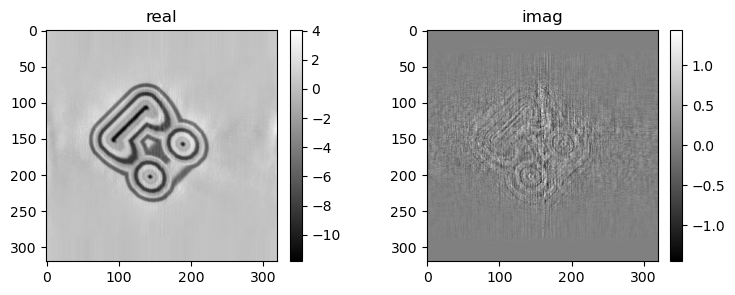

In [10]:
def hessian2(psi,ksi,eta,prb,data):
    Lksi = fwd_holo(ksi,prb)
    Leta = fwd_holo(eta,prb)
    Lpsi = fwd_holo(psi,prb)        

    v1 = cp.abs(Lpsi)-data
    v2 = cp.real(cp.conj(Lksi)*Leta)/cp.abs(Lpsi)            
    v3 = cp.real(cp.conj(Lpsi)*Lksi) * cp.real(cp.conj(Lpsi)*Leta) / cp.abs(Lpsi)**3    
    v4 = cp.real(cp.conj(Lpsi)*Lksi)/cp.abs(Lpsi)
    v5 = cp.real(cp.conj(Lpsi)*Leta)/cp.abs(Lpsi)
    return 2*(cp.sum(v1 * cp.conj(v2-v3)) + cp.sum(v4*cp.conj(v5)))


def cg(data, init_u, prb, pars):
    def minf(fpsi):
        f = np.linalg.norm(np.abs(fpsi)-data)**2
        return f

    data = np.sqrt(data)
    u = init_u.copy()    
    conv = np.zeros(pars['niter'])
    step = np.zeros(pars['niter'])    
    center_pad = u.shape[-1]//2
    for i in range(pars['niter']):
        
        # \nabla(F)_X
        eR = cp.exp(1j*R(u,theta,center_pad).swapaxes(0,1))
        Lpsi = fwd_holo(eR,prb)        
        gradx = 2*adj_holo(Lpsi-data*np.exp(1j*np.angle(Lpsi)),prb)        
               
        # \nabla(G)_U0
        grad = cp.conj(eR)*gradx
        grad = -1j*RT(grad.swapaxes(0,1),theta,center_pad)                                
        
        Rgrad = R(grad,theta,center_pad).swapaxes(0,1)
        
        # eta
        if i == 0:
            eta = -grad            
            Reta = -Rgrad
        else:                     
        
            h2u = cp.real(cp.sum(gradx*cp.conj(eR*(1j*Rgrad)*(1j*Reta))))         
            h2u += hessian2(eR,eR*(1j*Rgrad),eR*(1j*Reta),prb,data)

            h2b = cp.real(cp.sum(gradx*cp.conj(eR*(1j*Reta)*(1j*Reta))))         
            h2b += hessian2(eR,eR*(1j*Reta),eR*(1j*Reta),prb,data)

            beta = h2u/h2b
            
            eta = -grad + beta*eta
            Reta = -Rgrad + beta*Reta  

        # hessian
        
        h2 = cp.real(cp.sum(gradx*cp.conj(eR*(1j*Reta)**2)))         
        h2 += hessian2(eR,eR*(1j*Reta),eR*(1j*Reta),prb,data)
                
        gammah = -cp.sum(cp.real(grad*cp.conj(eta)))/h2
        u += gammah*eta
        
        if i % pars['err_step'] == 0:
            eR = cp.exp(1j*R(u,theta,u.shape[-1]//2).swapaxes(0,1))
            Lpsi = fwd_holo(eR,prb)
            err = minf(Lpsi)
            conv[i] = err
            step[i] = gammah
            print(f'{i}), {float(gammah)=} {err=:1.5e}')

        if i % pars['vis_step'] == 0:
            mshow_complex(u[:,ne//2+3,:],show)            
            
    return u,conv,step
psirec = cp.pad(cp.array(recMultiPaganin),((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'edge')

#tomo initial guess
xi = 1/1j*cp.log(psirec).swapaxes(0,1)


urec = cp.zeros([ne,ne,ne],dtype='complex64')
pars = {'titer':65, 'gammau':0.5}
urec = cg_tomo(xi,urec,pars)

data = cp.array(data00)
rec_prb = cp.array(np.load(f'/data2/vnikitin/coded_apertures_new3/data/prb_{flg}.npy'))
shifts_code = cp.array(shifts_code)
pars = {'niter': 3000, 'err_step': 1, 'vis_step': 8}

urec,conv,step = cg(data, urec,rec_prb, pars)



In [ ]:
# k = f'gradhessians2'
# np.save(f'data/u_{k}_{pars['niter']}',urec.get())
# np.save(f'data/conv_{k}',conv)
# np.save(f'data/step_{k}',step)
# mshow_complex(urec[:,128],show)